## 2. Geo Code Extraction

To-dos:

* utilise the EDA notebook and extract the Geocode for all addresses
* Merge with clean data and generate output file

# Step 1: Getting Started

First we're going to load in the data we prepared in notebook [1. Data Acquisition](1. Data Acquisition.ipynb) and have a quick look at it's structure:

In [1]:
import pandas as pd
import geocoder # For extracting geo coordinates
from time import sleep

data = pd.read_csv('../data/price_history.csv.gz', compression='gzip')

data.head(10)

,ServiceStationName,Address,Suburb,Postcode,Brand,FuelCode,PriceUpdatedDate,Price
0,Metro Petroleum Islington,"144 Maitland Rd, ISLINGTON NSW 2296",ISLINGTON,2296.0,Metro Fuel,E10,2017-10-01 00:02:52,116.9
1,Independent Punchbowl,"10-12 Park Ave, Punchbowl NSW 2196",Punchbowl,2196.0,Independent,E10,2017-10-01 00:08:44,119.9
2,Independent Punchbowl,"10-12 Park Ave, Punchbowl NSW 2196",Punchbowl,2196.0,Independent,P98,2017-10-01 00:08:44,139.9
3,Independent Punchbowl,"10-12 Park Ave, Punchbowl NSW 2196",Punchbowl,2196.0,Independent,U91,2017-10-01 00:08:44,122.9
4,Metro Minto,"1 Brookfield Road, Minto NSW 2566",Minto,2566.0,Metro Fuel,E10,2017-10-01 00:13:51,133.9
5,7-Eleven Penrith,"588 High Street, Penrith NSW 2751",Penrith,2751.0,7-Eleven,PDL,2017-10-01 00:24:40,125.9
6,Metro Fuel Berkeley,"57 Winnima Way, Berkeley NSW 2056",Berkeley,2056.0,Metro Fuel,E10,2017-10-01 05:03:52,114.9
7,Metro Fuel Berkeley,"57 Winnima Way, Berkeley NSW 2056",Berkeley,2056.0,Metro Fuel,U91,2017-10-01 05:03:52,116.9
8,Independent Wiley Park,"107 King Georges Rd, Wiley Park NSW 2195",Wiley Park,2195.0,Independent,E10,2017-10-01 05:18:53,135.9
9,Independent Wiley Park,"107 King Georges Rd, Wiley Park NSW 2195",Wiley Park,2195.0,Independent,P98,2017-10-01 05:18:53,149.9


We can see that we have `Price` at `PriceUpdatedDate`, for many combinations of `FuelCode` and `ServiceStationName`, and for each the relevant `Address`, `Suburb`, `Postcode` and `Brand`.

Now we want to start exploring the data. Looking at price changes over time seems like a good place to start.

To do that, we'll summarise `PriceUpdatedDate` (which is actually a *timestamp*) to the date level:

In [2]:
clean_data = data.copy()

# Convert PriceUpdateDate to datetime format
clean_data['PriceUpdatedDate'] = pd.to_datetime(clean_data['PriceUpdatedDate'])

# Extract the date component to a separate column
clean_data['PriceUpdatedDate_date'] = pd.to_datetime(clean_data['PriceUpdatedDate'].dt.date)

clean_data.head()

,ServiceStationName,Address,Suburb,Postcode,Brand,FuelCode,PriceUpdatedDate,Price,PriceUpdatedDate_date
0,Metro Petroleum Islington,"144 Maitland Rd, ISLINGTON NSW 2296",ISLINGTON,2296.0,Metro Fuel,E10,2017-10-01 00:02:52,116.9,2017-10-01
1,Independent Punchbowl,"10-12 Park Ave, Punchbowl NSW 2196",Punchbowl,2196.0,Independent,E10,2017-10-01 00:08:44,119.9,2017-10-01
2,Independent Punchbowl,"10-12 Park Ave, Punchbowl NSW 2196",Punchbowl,2196.0,Independent,P98,2017-10-01 00:08:44,139.9,2017-10-01
3,Independent Punchbowl,"10-12 Park Ave, Punchbowl NSW 2196",Punchbowl,2196.0,Independent,U91,2017-10-01 00:08:44,122.9,2017-10-01
4,Metro Minto,"1 Brookfield Road, Minto NSW 2566",Minto,2566.0,Metro Fuel,E10,2017-10-01 00:13:51,133.9,2017-10-01


Now we have everything we need to plot the mean `Price` reported daily:

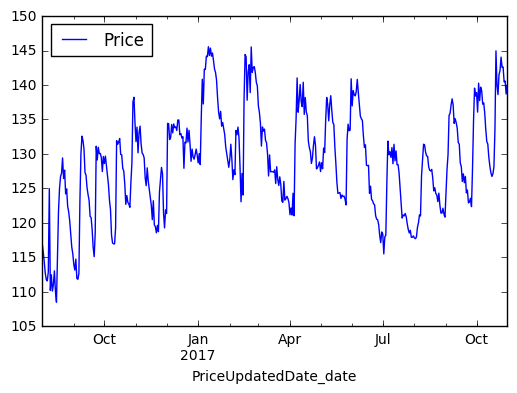

In [3]:
import seaborn as sns

% matplotlib inline

clean_data[['Price','PriceUpdatedDate_date']].groupby(['PriceUpdatedDate_date']).mean().plot();

Unforunately that is not all we have to do to create an accurate reflection of fuel prices across NSW. Since our data only reported *price changes*, what we have actually plotted is the mean *price update* daily.

# Step 2: Calculating daily prices

To solve this problem and allow us to plot mean daily *price*, we'll need to do some more data preparation.

Over the same period as our data, for each known combination of `FuelCode`, `ServiceStationName` and date, we want to create a view price history by looking up the *last known* `Price` from our data above.

In [4]:
import numpy as np

combos = clean_data[['FuelCode', 'ServiceStationName']].groupby(['FuelCode', 'ServiceStationName']).count().reset_index()

combos.head(10)

,FuelCode,ServiceStationName
0,B20,BP Port Kembla
1,B20,Independent Marrickville
2,B20,OneGov Testing & Support
3,CNG,Metro Petroleum Islington
4,CNG,Shell Gloucester
5,DL,7-Eleven Kanwal
6,DL,7-Eleven St Helens Park
7,DL,AP Punchbowl
8,DL,Aberdeen Fuels
9,DL,Access Fuels Ebor


In [5]:
import numpy as np

start  = clean_data['PriceUpdatedDate_date'].min()
end = clean_data['PriceUpdatedDate_date'].max()

cal = pd.DataFrame(pd.date_range(start, end), columns=['Date'])
cal.head()


,Date
0,2016-08-01
1,2016-08-02
2,2016-08-03
3,2016-08-04
4,2016-08-05


In [6]:
combo_cal = pd.merge(combos.assign(key=0), cal.assign(key=0), on='key').drop('key', axis=1)
combo_cal.head()

,FuelCode,ServiceStationName,Date
0,B20,BP Port Kembla,2016-08-01
1,B20,BP Port Kembla,2016-08-02
2,B20,BP Port Kembla,2016-08-03
3,B20,BP Port Kembla,2016-08-04
4,B20,BP Port Kembla,2016-08-05


In [7]:
last_price = clean_data.sort_values(by='PriceUpdatedDate', ascending=True)[['Price','FuelCode','ServiceStationName','PriceUpdatedDate_date']].groupby(['PriceUpdatedDate_date','FuelCode','ServiceStationName']).last().reset_index()
last_price.rename(columns = {'PriceUpdatedDate_date':'Date'}, inplace = True)
last_price.head()

,Date,FuelCode,ServiceStationName,Price
0,2016-08-01,DL,BP Airds,109.9
1,2016-08-01,DL,BP Blacktown,109.9
2,2016-08-01,DL,BP Cabramatta West,109.9
3,2016-08-01,DL,BP Kemps Creek,108.9
4,2016-08-01,DL,BP Leppington,108.9


In [8]:
daily_pricing = pd.merge(combo_cal, last_price, on=['Date','FuelCode','ServiceStationName'], how='left').fillna(method='ffill').dropna()

daily_pricing.head(20)

,FuelCode,ServiceStationName,Date,Price
141,B20,BP Port Kembla,2016-12-20,55.9
142,B20,BP Port Kembla,2016-12-21,55.9
143,B20,BP Port Kembla,2016-12-22,55.9
144,B20,BP Port Kembla,2016-12-23,55.9
145,B20,BP Port Kembla,2016-12-24,55.9
146,B20,BP Port Kembla,2016-12-25,55.9
147,B20,BP Port Kembla,2016-12-26,55.9
148,B20,BP Port Kembla,2016-12-27,55.9
149,B20,BP Port Kembla,2016-12-28,55.9
150,B20,BP Port Kembla,2016-12-29,55.9


## Step 3 Geocoding the Unique address 

Extract the unique values of address in list UniqueAdress
Then use google geocoder to extract co-ordinates

In [9]:
UniqueAdress=pd.DataFrame(list(data['Address'].unique()),columns=['Address'])


Method to extract geocodes

In [18]:
def Extract_geocode(df):
    df_coordinate=[]
    df_geojason=[]
    i=0
    for row in df['Address']:
        g=geocoder.google(row, key='Enteryourownkey')
        df_coordinate.append(g.latlng)
        df_geojason.append(g)
        i=i+1
        print("The address computed are ",i," ",g)
    return(df_coordinate,df_geojason)

In [12]:
#Call geocoder to call method
df_coordinate_f,df_geojason_f=Extract_geocode(UniqueAdress)

The address computed are  1   <[OK] Google - Geocode [Maitland Rd, Islington NSW 2296, Australia]>
The address computed are  2   <[OK] Google - Geocode [10-12 Park Ave, Punchbowl NSW 2196, Australia]>
The address computed are  3   <[OK] Google - Geocode [1 Brookfield Rd, Minto NSW 2566, Australia]>
The address computed are  4   <[OK] Google - Geocode [588 High St, Penrith NSW 2750, Australia]>
The address computed are  5   <[OK] Google - Geocode [57 Winnima Way, Berkeley NSW 2506, Australia]>
The address computed are  6   <[OK] Google - Geocode [107 King Georges Rd, Wiley Park NSW 2195, Australia]>
The address computed are  7   <[OK] Google - Geocode [150-158 Pacific Hwy, Tuggerah NSW 2259, Australia]>
The address computed are  8   <[OK] Google - Geocode #2 results>
The address computed are  9   <[OK] Google - Geocode [48-50 Aiken Rd, West Pennant Hills NSW 2125, Australia]>
The address computed are  10   <[OK] Google - Geocode [30 Bridge St, Epping NSW 2121, Australia]>
The address co

In [13]:
#Assigne coordiantes and geojson to new columns in Unique address
UniqueAdress=UniqueAdress.assign(Coordinates=pd.Series(df_coordinate_f).values,GeoJson=pd.Series(df_geojason_f).values)

In [14]:
#Sample data after geocoding
UniqueAdress.head()

,Address,Coordinates,GeoJson
0,"144 Maitland Rd, ISLINGTON NSW 2296","[-32.91359, 151.7472984]","[[Maitland Rd, Islington NSW 2296, Australia]]"
1,"10-12 Park Ave, Punchbowl NSW 2196","[-33.9180459, 151.0631799]","[[10-12 Park Ave, Punchbowl NSW 2196, Australia]]"
2,"1 Brookfield Road, Minto NSW 2566","[-34.031538, 150.8479658]","[[1 Brookfield Rd, Minto NSW 2566, Australia]]"
3,"588 High Street, Penrith NSW 2751","[-33.752464, 150.6910665]","[[588 High St, Penrith NSW 2750, Australia]]"
4,"57 Winnima Way, Berkeley NSW 2056","[-34.4801808, 150.8462221]","[[57 Winnima Way, Berkeley NSW 2506, Australia]]"


In [15]:
#merge data with clean_dataframe
clean_data_withgeocodes=pd.merge(clean_data,UniqueAdress,on='Address')/

In [17]:
#write data to output for future reference
clean_data_withgeocodes.to_csv('../output/clean_data',compression='gzip')